# **<font color="#FBBF44">Imports</font>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

# **<font color="#FBBF44">Functions</font>**

In [2]:
# Time limits for different sets of instances
timelimG = 7200
# To store runtimes and objective values
times = []
objectives = []

# Cost factors for large and Small vehicles
a1 = np.random.randint(5,10)/10 # = .8
a2 = a1*.75 # = .6

# Instance generator
def instance_gen(seed, clients, S1, S2, Q1, dmin, dmax):
    np.random.seed(seed) # Initial seed
    n = clients # number of clients
    # random location of clients within 8km radius
    xc = np.random.rand(n+1)*8 
    yc = np.random.rand(n+1)*8
    points = range(0,n+1)

    N = [i for i in range(1, n + 1)] # Set of clients
    V = [0] + N # Set of all nodes, including depot
    A = [(i,j) for i in V for j in V if i != j] # Available arcs between nodes
    
    S = S1 + S2 # Total amount of available vehicles
    K = [i for i in range(1, S + 1)] # Number of available vehicles, including large and small
    K1 = [i for i in range(1, S1 + 1)] # subset of large vehicles
    K2 = [i for i in range(S1+1, S1+S2+1)] # subset of small vehicles
    
    Ak = [(i,j,k) for k in K for i in V for j in V if i != j] # Available arcs between nodes for each vehicle
    Q = {} # Capacities
    for i in K:
        if i in K1:
            Q[i] = Q1 
        else:
            Q[i] = Q1/2

    d = {i: np.random.randint(dmin, dmax) for i in N} # Random demands from customers

    a1 = .8
    a2 = .6

    d1 = {(i,j,1): (np.hypot(xc[i] - xc[j], yc[i] - yc[j])) + np.random.rand() for i, j in A}
    d2 = {(i,j,2): d1[i,j,1] for i, j in A}
    c1 = {k:v*a1 for k, v in d1.items()} # Cost for traversing i,j with LargeVehicle
    c2 = {k:v*a2 for k, v in d2.items()} # Cost for traversing i,j with SmallVehicle
    c = dict(c1)
    c.update(c2) 
    return n, xc, yc, points, list(N), V, K, K1, K2, A, Ak, S, Q, d, c

In [3]:
# Building the model
def build_model(model):
    model = gp.Model()
    x = model.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
    y = model.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
    u = model.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
    z = model.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
    M = 1000 # Big M

    # objective
    model.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2), GRB.MINIMIZE)
    # (1)
    c1 = model.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
    # (2)
    c2 = model.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
    # (3)
    c3 = model.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
    # (4)
    c4 = model.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
    # (5)
    c5 = model.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
    # (6)
    c6 = model.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
    # (7)
    c7 = model.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
    # (8)
    c8 = model.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
    c8_2 = model.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)
    
    return model, x, y, u, z, c2

In [4]:
# Plotting solution
def plot_sol(xc, yc, K1, K2, active_arcs, name):
    colors = ["teal", "darkorange", "violet", "indigo", "turquoise", "crimson", "gold", "limegreen", "royalblue"]
    plt.plot(xc[0], yc[0], c='red', marker='s', label="Depot")
    plt.scatter(xc[1:], yc[1:], label="Clients")
#     for i in range(len(xc)):
#         plt.annotate(points[i], (xc[i] - .5, yc[i] + 0.4))
    
    for k in K1:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))
    for k in K2:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))

    plt.xlim((-0.5, 8.5))
    plt.ylim((-0.5, 8.5))
    handles, labels = plt.gca().get_legend_handles_labels()
    lines = {}
    K = K1 + K2
    for k in K:
        if k in K1:
            lines[k] = Line2D([0], [0], label='LargeVehicle {}'.format(k), color = colors[k-1]) #, color='teal')
        else:
            lines[k] = Line2D([0], [0], label='SmallVehicle {}'.format(k), color = colors[k-1]) #, color='teal')

    handles.extend(lines.values())

    plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
    plt.title("Selected routes for {}".format(name))
    plt.savefig("FigXX-Tour{}".format(name)+".png", bbox_inches='tight', dpi=600) 
    plt.show()

In [5]:
# Finding the edges from solution values, as a tuplelist for each k
def selected(vals):
    s = {k:gp.tuplelist() for k in K}
    for i, j, k in vals.keys():
        if vals[i,j,k] > 0.99:
            s[k].append((i,j))
    return s
       
# Given the edges, finding the optimal route for each k
def subtour(edges):
    nodes = set(i for e in edges for i in e)
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle): # even if it's the same, we reuse it so that we get the final tour in order
            cycle = thiscycle # New shortest subtour
    return cycle

# Print each tour
def print_route(objective, edges):
    print(f"The optimal cost for the distance traveled is: {(round(objective,2))} €")
    for k in K:
        tour = subtour(edges[k])
        tour.append(0) # return to depot
        print ("Route for vehicle k%i: %s" % (k, " -> ".join(map(str, tour))))

In [6]:
# Check for feasibility by confirming total delivery and delivery by vehicle doesn't exceed capacities, also check if customers are satisfied
def feasibility_check(yvals):
    print("---------------------------")
    print("Feasibility check:")
    print(f"Total capacity: {sum(Q.values())}")
    print(f"Total amount delivered: {sum(d.values())}")
    print(f"Capacity of large vehicles: {Q[1]}")
    # Get amount delivered by each k vehicle
    for k in K:
        delivery_by_vehicle = [yvals[i,j] for i,j in yvals if j == k] 
        print("Amount delivered by vehicle k%i: %i" % (k, sum(delivery_by_vehicle)))
        if sum(delivery_by_vehicle) > Q[k]:
            exceedsQ = "Yes"
        else:
            exceedsQ = "No"
    # Get amount delivered to each customer, independent of k
    for h in N:
        delivery_to_costumer = [yvals[i,j] for i,j in yvals if i == h]
        if sum(delivery_to_costumer) == d[h]:
            customers_satisfied = "Yes"
        else: 
            customers_satisfied = "No"
    if sum(d.values()) <= sum(Q.values()) and exceedsQ == "No" and customers_satisfied == "Yes":
        print("All customers are satisfied, capacities are respected, model is feasible")
    else:
        print("Model is infeasible")

In [7]:
# Function for parameter tuning
def print_tuning(model, timelimit):
    model.Params.TuneTimeLimit = timelimit
    model.tune()
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write('tune'+str(i)+'.prm')

In [8]:
# Function to see which MIPFocus performs best on first seconds of optimization
def MIPcomparison(model, timelimit):
    gaps = []
    model.Params.TimeLimit = timelimit
    model.Params.OutPutFlag = 0
    for i in range(0, 4):
        model.reset()
        model.Params.MIPFocus = i
        model.optimize()
        gaps.append(model.MIPGap)
    print(f"MIPFocus 0,1,2,3:{gaps}")

In [9]:
# Retrieve gaps and runtimes from the log file
def gap_runtime(instance):
    gap = []
    runtime = []
    incumbent = []
    bestbd = []
    with open(instance+".log") as file:
        for line in file:
            if "Node Time" in line:
                for line in file:
                    row = line.split() 
                    row = [r.strip("%") for r in row]
                    row = [r.strip("s") for r in row]
                    gap.append(row[-3:])
                    runtime.append(row[-1:])
                    incumbent.append(row[-5:])
                    bestbd.append(row[-4:])
                    if "Cutting" in line:
                        break
    gap = gap[1:-2]
    for i in gap:
        del i[1:3]
    gap = [i[0] for i in gap]
    for i in range(len(gap)):
        if gap[i] == '-':
            gap[i] = 100
    gap = [float(i) for i in gap]

    runtime = runtime[1:-2]
    runtime = [int(i[0]) for i in runtime]

    incumbent = incumbent[1:-2]
    for i in incumbent:
        del i[1:3]
    incumbent = [i[0] for i in incumbent]
    for i in range(len(incumbent)):
        if incumbent[i] == '-':
            incumbent[i] = incumbent[i+1]
    incumbent = [float(i) for i in incumbent]

    bestbd = bestbd[1:-2]
    bestbd = [float(i[0]) for i in bestbd]
    
    return gap, runtime, incumbent, bestbd

# **<font color="#BBBF">G INSTANCES</font>**

## **<font color="#FBBF44">G-01</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 2400
Set parameter MIPFocus to value 3
Set parameter LogFile to value "G-01.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 116286 rows, 58800 columns and 7287600 nonzeros
Model fingerprint: 0x2d118449
Variable types: 29040 continuous, 29760 integer (29280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

User MIP start produced solution with objective 469.107 (2.18s)
Loaded user MIP start with objective 469.107
Processed MIP start in 2.17 seconds (0.48 work units)

Presolve removed 86760 rows and 29160 columns
Presolve time: 2.81s
Presolved: 29526 rows, 29640 columns, 174000 nonzeros
Crushed 2 out

Found heuristic solution: objective 91.1655419
Elapsed time for NoRel heuristic: 85s (best bound 64.1734)
Found heuristic solution: objective 90.2649164
Elapsed time for NoRel heuristic: 91s (best bound 64.1734)
Found heuristic solution: objective 90.2649153
Elapsed time for NoRel heuristic: 96s (best bound 64.1734)
Elapsed time for NoRel heuristic: 102s (best bound 64.1734)
Found heuristic solution: objective 90.0747442
Found heuristic solution: objective 90.0582315
Elapsed time for NoRel heuristic: 111s (best bound 64.1734)
Found heuristic solution: objective 89.8509286
Elapsed time for NoRel heuristic: 119s (best bound 64.1734)
Found heuristic solution: objective 89.8133207
Found heuristic solution: objective 89.0612477
Elapsed time for NoRel heuristic: 124s (best bound 64.1734)
Found heuristic solution: objective 88.9262039
Elapsed time for NoRel heuristic: 133s (best bound 64.1734)
Found heuristic solution: objective 88.8511244
Elapsed time for NoRel heuristic: 139s (best bound 64

     0     0   71.87652    0  975   82.81489   71.87652  13.2%     - 2681s
     0     0   71.87905    0  958   82.81489   71.87905  13.2%     - 2681s
     0     0   71.87916    0  960   82.81489   71.87916  13.2%     - 2681s
     0     0   71.90315    0  924   82.81489   71.90315  13.2%     - 2714s
     0     0   71.91458    0  963   82.81489   71.91458  13.2%     - 2714s
     0     0   71.92060    0 1000   82.81489   71.92060  13.2%     - 2715s
     0     0   71.92102    0  980   82.81489   71.92102  13.2%     - 2715s
     0     0   71.93930    0 1010   82.81489   71.93930  13.1%     - 2745s
     0     0   71.94325    0 1011   82.81489   71.94325  13.1%     - 2747s
     0     0   71.94387    0 1028   82.81489   71.94387  13.1%     - 2748s
     0     0   71.99485    0  945   82.81489   71.99485  13.1%     - 2785s
     0     0   72.00095    0  964   82.81489   72.00095  13.1%     - 2785s
     0     0   72.00263    0  947   82.81489   72.00263  13.1%     - 2785s
     0     0   72.02745  

  1077  1065   72.58742   14  833   82.81489   72.58742  12.3%   168 5474s
  1081  1068   72.65370   15  925   82.81489   72.58742  12.3%   169 5483s
  1085  1071   72.58742   16 1002   82.81489   72.58742  12.3%   169 5495s
  1089  1073   72.67454   15  935   82.81489   72.58742  12.3%   170 5504s
  1093  1076   72.58742   15  867   82.81489   72.58742  12.3%   170 5513s
  1097  1079   72.72247   19  805   82.81489   72.58742  12.3%   171 5525s
  1101  1081   72.66409   17  898   82.81489   72.58742  12.3%   171 5569s
  1105  1084   72.58742   18  994   82.81489   72.58742  12.3%   172 5579s
  1109  1088   72.65790   17  826   82.81489   72.58742  12.3%   173 5588s
  1114  1090   72.88668   18  850   82.81489   72.58742  12.3%   174 5596s
  1118  1093   72.58742   16  886   82.81489   72.58742  12.3%   174 5605s
  1122  1103   72.60246   17  843   82.81489   72.58742  12.3%   174 5610s
  1134  1115   72.67922   21  967   82.81489   72.59611  12.3%   173 5615s
  1150  1128   72.83142  

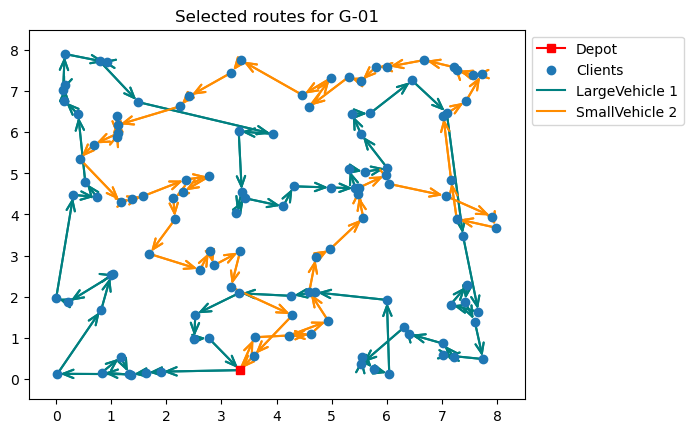

The optimal cost for the distance traveled is: 82.81 €
Route for vehicle k1: 0 -> 95 -> 12 -> 28 -> 44 -> 57 -> 75 -> 98 -> 60 -> 119 -> 49 -> 14 -> 2 -> 27 -> 5 -> 114 -> 64 -> 38 -> 120 -> 106 -> 50 -> 90 -> 30 -> 6 -> 54 -> 61 -> 31 -> 94 -> 86 -> 67 -> 9 -> 105 -> 51 -> 66 -> 59 -> 82 -> 34 -> 15 -> 118 -> 73 -> 102 -> 117 -> 32 -> 25 -> 112 -> 76 -> 91 -> 21 -> 29 -> 70 -> 24 -> 20 -> 43 -> 23 -> 62 -> 1 -> 115 -> 39 -> 69 -> 33 -> 63 -> 35 -> 22 -> 7 -> 0
Route for vehicle k2: 0 -> 92 -> 93 -> 101 -> 99 -> 56 -> 58 -> 89 -> 113 -> 11 -> 36 -> 41 -> 116 -> 80 -> 40 -> 109 -> 46 -> 85 -> 13 -> 107 -> 87 -> 68 -> 104 -> 96 -> 37 -> 78 -> 79 -> 108 -> 88 -> 97 -> 81 -> 17 -> 10 -> 74 -> 3 -> 42 -> 72 -> 111 -> 71 -> 18 -> 26 -> 55 -> 4 -> 110 -> 19 -> 47 -> 77 -> 48 -> 53 -> 84 -> 52 -> 100 -> 83 -> 103 -> 16 -> 8 -> 65 -> 45 -> 0
Runtime = 7200.269533157349
---------------------------
Feasibility check:
Total capacity: 1200.0
Total amount delivered: 835
Capacity of large vehicles: 8

In [10]:
############ Instance Initialization G-01 ############
name = "G-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=120,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=800,
                                                                     dmin=5,
                                                                     dmax=10)
############ model15 Construction ############
model11 = gp.Model("model11")
x = model11.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model11.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model11.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model11.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model11.addVar() for _ in x]
model11.update()

# Lagrangian Multiplier
multiplier = [2] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model11.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model11.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model12.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model11.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model11.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model11.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model11.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model11.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model11.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model11.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

model11.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model12.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model12.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2
model11.read("MIPStarts\G-01.sol")
    
for k in range(1, 3):
    model11.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model11.Params.TimeLimit = timelimG  # Time limit
    model11.Params.NoRelHeurTime = 2400
    model11.Params.MIPFocus = 3
    model11.Params.LogFile = name+".log"
    model11.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)

############ Plotting Solution ############
if model11.solcount >= 1:
    model11.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model11.getAttr('X', x)
    yvals = model11.getAttr('X', y)
    print_route(objective=model11.objVal, edges=selected(vals))
    times.append(model11.runtime)
    print(f"Runtime = {model11.runtime}")
    feasibility_check(yvals)
    objectives.append(model11.objVal)
else:
    print("No feasible solution found")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 800
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58206 rows, 29760 columns and 231360 nonzeros
Model fingerprint: 0x39be789c
Variable types: 0 continuous, 29760 integer (29280 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 469.107

Presolve removed 28680 rows and 120 columns
Presolve time: 0.49s
Presolved: 29526 rows, 29640 columns, 173760 nonzeros
Extracted 2 lazy constraints
Variable types: 0 continuous, 29640 integer (29280 binary)
Starting NoRel heuristic
Found heuristic solution: objective 468.7795348
Found heuristic solution

Found heuristic solution: objective 90.4959701
Found heuristic solution: objective 90.3373708
Elapsed time for NoRel heuristic: 401s (best bound 65.4467)
Elapsed time for NoRel heuristic: 421s (best bound 65.4467)
Elapsed time for NoRel heuristic: 428s (best bound 65.4467)
Elapsed time for NoRel heuristic: 450s (best bound 65.4467)
Elapsed time for NoRel heuristic: 526s (best bound 65.4467)
Elapsed time for NoRel heuristic: 594s (best bound 65.4467)
Elapsed time for NoRel heuristic: 690s (best bound 65.4467)
Elapsed time for NoRel heuristic: 761s (best bound 65.4467)
Found heuristic solution: objective 90.0922619
Found heuristic solution: objective 89.4079626
Found heuristic solution: objective 89.3654360
Elapsed time for NoRel heuristic: 834s (best bound 65.4467)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0892097e+01   9.231250e+01   4.378

  2662  2440   74.94337   49  287   86.27397   71.81004  16.8%  42.1 1466s
  2684  2470   74.80739   52  540   86.27397   71.81004  16.8%  42.6 1472s
  2708  2481   74.80936   53  544   86.27397   71.81004  16.8%  43.0 1476s
  2753  2500   74.81804   58  546   86.27397   71.81004  16.8%  43.5 1482s
  2775  2514   75.66825   60  531   86.27397   71.81004  16.8%  44.2 1485s
  2819  2546   74.83818   64  501   86.27397   71.81004  16.8%  45.2 1492s
  2849  2559   74.84313   67  490   86.27397   71.81004  16.8%  45.5 1496s
  2872  2573 infeasible   69        86.27397   71.81004  16.8%  46.1 1500s
  2923  2597   77.17042   74  266   86.27397   71.81004  16.8%  47.4 1507s
  2947  2613   77.19686   77  247   86.27397   71.81004  16.8%  48.0 1511s
  2974  2630 infeasible   80        86.27397   71.81004  16.8%  48.5 1515s
  3046  2676   77.89727   85  300   86.27397   71.81004  16.8%  49.5 1523s
  3086  2696   78.23294   88  310   86.27397   71.81004  16.8%  50.0 1527s
  3134  2725   77.92573  

 20970 14232   80.29939  173  830   85.52393   72.21521  15.6%  62.3 3816s
 20971 14233   72.66344   30  843   85.52393   72.21521  15.6%  62.3 3841s
 20972 14233   81.73861  176  840   85.52393   72.21538  15.6%  62.3 3863s
 20973 14234   83.42676  252  843   85.52393   72.21538  15.6%  62.3 3889s
 20974 14235   85.14604  199  840   85.52393   72.21769  15.6%  62.3 3917s
H20974 13523                      85.5239277   72.21776  15.6%  62.3 3944s
 20976 13524   81.18488  153  824   85.52393   72.21835  15.6%  62.3 3975s
 20977 13525   79.46607  139  833   85.52393   72.21837  15.6%  62.3 4000s
 20978 13525   75.28980  110  846   85.52393   72.21862  15.6%  62.3 4056s
 20979 13526   74.76369  102  838   85.52393   72.21873  15.6%  62.3 4096s
 20980 13527   76.82496  111  841   85.52393   72.21877  15.6%  62.3 4125s
 20981 13527   74.06482   71  842   85.52393   72.21878  15.6%  62.3 4151s
 20982 13528   77.79275  120  841   85.52393   72.21878  15.6%  62.3 4182s
 20983 13529   80.30045  

 23662 13846   81.70038  229  276   84.91506   72.30991  14.8%  64.6 6317s
 23813 14004   82.64830  247  232   84.91506   72.34775  14.8%  64.6 6336s
 24050 14168   72.39058   33  695   84.91506   72.34775  14.8%  64.6 6358s
 24293 14284   73.83472   78  290   84.91506   72.34775  14.8%  64.6 6377s
 24507 14470   73.91882  106  315   84.91506   72.34775  14.8%  64.5 6397s
 24773 14656   76.21687  131  465   84.91506   72.34775  14.8%  64.4 6419s
 25100 14807   77.31806  176  378   84.91506   72.34775  14.8%  64.2 6443s
 25368 14958   77.55569  214  303   84.91506   72.34775  14.8%  64.3 6463s
 25646 15157   79.74346  258  353   84.91506   72.34775  14.8%  64.3 6487s
 26006 15331   82.59714  325  353   84.91506   72.35290  14.8%  64.1 6512s
 26325 15571   77.25889   89  401   84.91506   72.35290  14.8%  64.1 6543s
 26687 15765   82.22412  151  332   84.91506   72.35933  14.8%  64.1 6577s
 27054 15647   72.61988   46  772   84.91506   72.35933  14.8%  64.1 6606s
 27058 15954   72.88839  

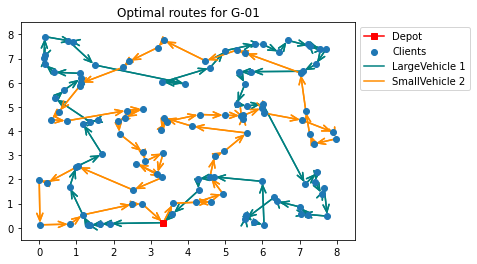

The optimal cost for the distance traveled is: 84.92 €
Route for vehicle k1: 0 -> 95 -> 12 -> 28 -> 75 -> 57 -> 60 -> 119 -> 52 -> 4 -> 19 -> 110 -> 55 -> 26 -> 72 -> 111 -> 64 -> 38 -> 120 -> 106 -> 50 -> 90 -> 30 -> 6 -> 54 -> 61 -> 97 -> 81 -> 79 -> 78 -> 73 -> 37 -> 104 -> 96 -> 68 -> 87 -> 107 -> 102 -> 118 -> 15 -> 34 -> 66 -> 59 -> 82 -> 25 -> 112 -> 76 -> 91 -> 32 -> 21 -> 29 -> 70 -> 24 -> 20 -> 43 -> 23 -> 62 -> 1 -> 115 -> 39 -> 69 -> 33 -> 65 -> 45 -> 0
Route for vehicle k2: 0 -> 92 -> 93 -> 101 -> 99 -> 56 -> 58 -> 89 -> 113 -> 67 -> 31 -> 94 -> 86 -> 9 -> 105 -> 51 -> 11 -> 36 -> 41 -> 116 -> 80 -> 40 -> 109 -> 117 -> 46 -> 85 -> 13 -> 108 -> 88 -> 17 -> 10 -> 74 -> 3 -> 42 -> 18 -> 71 -> 114 -> 27 -> 5 -> 47 -> 77 -> 48 -> 53 -> 84 -> 83 -> 103 -> 16 -> 8 -> 100 -> 63 -> 35 -> 49 -> 14 -> 2 -> 98 -> 44 -> 57 -> 22 -> 7 -> 0
Runtime = 7200.173442840576
---------------------------
Feasibility check:
Total capacity: 1200.0
Total amount delivered: 835
Capacity of large vehic

In [9]:
# LazyConstraints + MIPStart
############ Instance Initialization G-01 ############
name = "G-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=120,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=800,
                                                                     dmin=5,
                                                                     dmax=10)
############ model11 Construction ############
model11, x, y, u, z, c2 = build_model("model11")
for k in c2:
    c2[k].Lazy = 1

############ model11 Solving ############
model11.reset()
model11.Params.TimeLimit = timelimG # Time limit
model11.Params.LogFile = name+".log"
model11.Params.NoRelHeurTime = 800
# model11.Params.MIPFocus = 3
# model11.Params.Cuts = 2
# model11.Params.Presolve = 2
model11.read("MIPStarts\G-01.sol")
model11.optimize()

############ Plotting Solution ############
if model11.solcount >= 1:
    # model11.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model11.getAttr('X', x)
    yvals = model11.getAttr('X', y)
    print_route(objective=model11.objVal, edges=selected(vals))
    times.append(model11.runtime)
    print(f"Runtime = {model11.runtime}")
    feasibility_check(yvals)
    objectives.append(model11.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-02</font>**

Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 2400
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 296246 rows, 119700 columns and 25521720 nonzeros
Model fingerprint: 0x1d099693
Variable types: 59220 continuous, 60480 integer (59640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 7s
User MIP start produced solution with objective 167.183 (8.51s)
Loaded user MIP start with objective 167.183
Processed MIP start in 8.50 seconds (1.76 work units)

Presolve removed 178080 rows and 59220 columns (presolve time = 6s) ...
Presolve removed 236040 rows and 59220 columns
Presolve time: 8.68s
Presolved: 60206 rows, 60480 columns, 354900 non

Elapsed time for NoRel heuristic: 261s (best bound 78.9151)
Elapsed time for NoRel heuristic: 278s (best bound 78.9151)
Elapsed time for NoRel heuristic: 291s (best bound 78.9151)
Found heuristic solution: objective 112.1903182
Elapsed time for NoRel heuristic: 371s (best bound 78.9151)
Found heuristic solution: objective 111.4956362
Elapsed time for NoRel heuristic: 390s (best bound 78.9151)
Found heuristic solution: objective 111.1864472
Elapsed time for NoRel heuristic: 403s (best bound 78.9151)
Elapsed time for NoRel heuristic: 415s (best bound 78.9151)
Found heuristic solution: objective 110.9937016
Elapsed time for NoRel heuristic: 439s (best bound 78.9151)
Found heuristic solution: objective 110.9405560
Found heuristic solution: objective 110.7791233
Found heuristic solution: objective 110.7236751
Elapsed time for NoRel heuristic: 452s (best bound 78.9151)
Found heuristic solution: objective 110.7209074
Found heuristic solution: objective 110.6974174
Elapsed time for NoRel heuri

     0     0   87.04353    0  957  102.63846   87.04353  15.2%     - 2892s
     0     0   87.06958    0 1192  102.63846   87.06958  15.2%     - 2907s
     0     0   87.06997    0 1142  102.63846   87.06997  15.2%     - 2907s
     0     0   87.18976    0 1180  102.63846   87.18976  15.1%     - 2960s
     0     0   87.19090    0 1382  102.63846   87.19090  15.1%     - 2961s
     0     0   87.23941    0 1229  102.63846   87.23941  15.0%     - 3013s
     0     0   87.24527    0 1366  102.63846   87.24527  15.0%     - 3017s
     0     0   87.24635    0 1408  102.63846   87.24635  15.0%     - 3018s
H    0     0                     102.6384564   87.38978  14.9%     - 3076s
     0     0   87.38978    0 1149  102.63846   87.38978  14.9%     - 3076s
     0     0   87.39544    0 1389  102.63846   87.39544  14.9%     - 3077s
     0     0   87.39555    0 1414  102.63846   87.39555  14.9%     - 3077s
     0     0   87.66517    0 1259  102.63846   87.66517  14.6%     - 3139s
     0     0   87.69450  

  1065  1009   89.06300   15 1465  102.63471   88.63979  13.6%   312 5158s
  1066  1010   89.33924   33 1515  102.63471   88.63979  13.6%   312 5169s
  1067  1011   89.69379    5 1519  102.63471   88.63979  13.6%   312 5173s
  1068  1011   89.15432   26 1538  102.63471   88.63979  13.6%   311 5176s
  1070  1013   89.26220   24 1699  102.63471   88.63979  13.6%   311 5243s
  1071  1013   89.06379   19 1393  102.63471   88.63979  13.6%   310 5348s
  1073  1015   89.07160   20 1586  102.63471   88.63979  13.6%   310 5422s
  1074  1015   88.99942   20 1571  102.63471   88.63979  13.6%   310 5524s
  1075  1016   88.80085    6 1620  102.63471   88.63979  13.6%   309 5525s
  1077  1017   89.34547   34 1693  102.63471   88.63979  13.6%   309 5611s
H 1077   966                     102.6347072   88.63979  13.6%   309 5703s
  1079   968   88.98965   27 1661  102.63471   88.63979  13.6%   308 5792s
  1080   968   88.92024   20 1631  102.63471   88.63979  13.6%   308 5906s
  1081   969   88.82926  

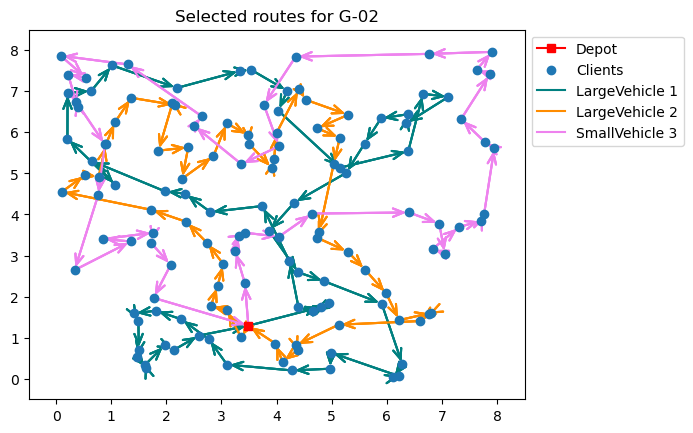

The optimal cost for the distance traveled is: 102.63 €
Route for vehicle k1: 0 -> 61 -> 7 -> 80 -> 2 -> 11 -> 30 -> 29 -> 64 -> 56 -> 51 -> 12 -> 81 -> 1 -> 19 -> 24 -> 125 -> 95 -> 69 -> 65 -> 70 -> 96 -> 104 -> 74 -> 42 -> 36 -> 78 -> 75 -> 121 -> 93 -> 113 -> 33 -> 135 -> 114 -> 92 -> 15 -> 62 -> 47 -> 116 -> 10 -> 48 -> 83 -> 109 -> 131 -> 26 -> 117 -> 123 -> 129 -> 14 -> 6 -> 31 -> 122 -> 9 -> 71 -> 0
Route for vehicle k2: 0 -> 112 -> 73 -> 86 -> 52 -> 76 -> 43 -> 128 -> 132 -> 77 -> 21 -> 23 -> 89 -> 101 -> 98 -> 79 -> 110 -> 139 -> 8 -> 133 -> 66 -> 35 -> 3 -> 46 -> 119 -> 17 -> 41 -> 87 -> 44 -> 82 -> 108 -> 140 -> 127 -> 25 -> 118 -> 97 -> 39 -> 103 -> 100 -> 53 -> 18 -> 115 -> 32 -> 50 -> 120 -> 13 -> 84 -> 0
Route for vehicle k3: 0 -> 22 -> 54 -> 85 -> 45 -> 20 -> 37 -> 60 -> 102 -> 99 -> 16 -> 111 -> 40 -> 59 -> 58 -> 88 -> 107 -> 68 -> 49 -> 137 -> 136 -> 105 -> 134 -> 34 -> 4 -> 90 -> 5 -> 38 -> 126 -> 57 -> 55 -> 138 -> 67 -> 124 -> 130 -> 91 -> 63 -> 27 -> 28 -> 94 -> 

In [33]:
# MIPstart + lagrangian + Params
############ Instance Initialization G-02 ############
name = "G-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=140,
                                                                     S1=2,
                                                                     S2=1,
                                                                     Q1=560,
                                                                     dmin=5,
                                                                     dmax=10)
############ model12 Construction ############
model12 = gp.Model("model12")
x = model12.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model12.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model12.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model12.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model12.addVar() for _ in x]
model12.update()

# Lagrangian Multiplier
multiplier = [2] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model12.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model12.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model12.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model12.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model12.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model12.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model12.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model12.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model12.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model12.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

# model12.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model12.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model12.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2
model12.read("MIPStarts\G-02.sol")
    
for k in range(1, 3):
    model12.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model12.Params.TimeLimit = timelimG  # Time limit
    model12.Params.NoRelHeurTime = 2400
    model12.Params.LogFile = name+".log"
    model12.Params.MIPFocus = 3
    model12.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)

############ Plotting Solution ############
if model12.solcount >= 1:
    model12.write(name+".sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model12.getAttr('X', x)
    yvals = model12.getAttr('X', y)
    print_route(objective=model12.objVal, edges=selected(vals))
    times.append(model12.runtime)
    print(f"Runtime = {model12.runtime}")
    feasibility_check(yvals)
    objectives.append(model12.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-03</font>**

Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 2400
Set parameter MIPFocus to value 3
Set parameter LogFile to value "G-03.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 618412 rows, 208000 columns and 67281280 nonzeros
Model fingerprint: 0x85a49b75
Variable types: 103040 continuous, 104960 integer (103680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 5s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 16s
User MIP start did not produce a new incumbent solution
User MIP start violates constraint R618410 by 78.000000000
Processed MIP start in 15.74 seconds (1.89 work units)

Presolve removed 412160 rows and 103040 columns (presolve 

Found heuristic solution: objective 168.7695665
Elapsed time for NoRel heuristic: 80s (best bound 80.2438)
Found heuristic solution: objective 168.4359086
Found heuristic solution: objective 167.9794808
Found heuristic solution: objective 166.0103863
Elapsed time for NoRel heuristic: 87s (best bound 80.2438)
Found heuristic solution: objective 164.9233531
Found heuristic solution: objective 164.5303873
Found heuristic solution: objective 164.2159554
Found heuristic solution: objective 163.1030422
Elapsed time for NoRel heuristic: 95s (best bound 80.2438)
Found heuristic solution: objective 161.5238087
Found heuristic solution: objective 161.4283530
Found heuristic solution: objective 161.1794146
Elapsed time for NoRel heuristic: 104s (best bound 80.2438)
Found heuristic solution: objective 160.2311892
Elapsed time for NoRel heuristic: 109s (best bound 80.2438)
Found heuristic solution: objective 159.8251169
Found heuristic solution: objective 159.6665735
Found heuristic solution: objec

Elapsed time for NoRel heuristic: 1625s (best bound 80.2438)
Found heuristic solution: objective 120.1525835
Found heuristic solution: objective 119.9699974
Elapsed time for NoRel heuristic: 1691s (best bound 80.2438)
Found heuristic solution: objective 119.9312357
Elapsed time for NoRel heuristic: 1772s (best bound 80.2438)
Found heuristic solution: objective 119.8924689
Found heuristic solution: objective 119.8435914
Elapsed time for NoRel heuristic: 1854s (best bound 80.2438)
Elapsed time for NoRel heuristic: 1931s (best bound 80.2438)
Elapsed time for NoRel heuristic: 2036s (best bound 80.2438)
Found heuristic solution: objective 119.5810859
Elapsed time for NoRel heuristic: 2105s (best bound 80.2438)
Found heuristic solution: objective 119.5183815
Elapsed time for NoRel heuristic: 2174s (best bound 80.2438)
Elapsed time for NoRel heuristic: 2255s (best bound 80.2438)
Found heuristic solution: objective 119.1404931
Elapsed time for NoRel heuristic: 2354s (best bound 80.2438)
Elapse

     0     0   89.79006    0 1722  119.14049   89.79006  24.6%     - 4284s
     0     0   89.79035    0 1658  119.14049   89.79035  24.6%     - 4285s
     0     0   89.80146    0 1615  119.14049   89.80146  24.6%     - 4371s
     0     0   89.80311    0 1722  119.14049   89.80311  24.6%     - 4373s
     0     0   89.80322    0 1856  119.14049   89.80322  24.6%     - 4373s
     0     0   89.83079    0 1426  119.14049   89.83079  24.6%     - 4437s
     0     0   89.83392    0 1782  119.14049   89.83392  24.6%     - 4439s
     0     0   89.83641    0 1735  119.14049   89.83641  24.6%     - 4440s
     0     0   89.83878    0 1813  119.14049   89.83878  24.6%     - 4440s
     0     0   89.83928    0 1857  119.14049   89.83928  24.6%     - 4441s
     0     0   89.84988    0 1450  119.14049   89.84988  24.6%     - 4517s
     0     0   89.85027    0 1432  119.14049   89.85027  24.6%     - 4519s
     0     0   89.85304    0 1325  119.14049   89.85304  24.6%     - 4575s
     0     0   89.85349  

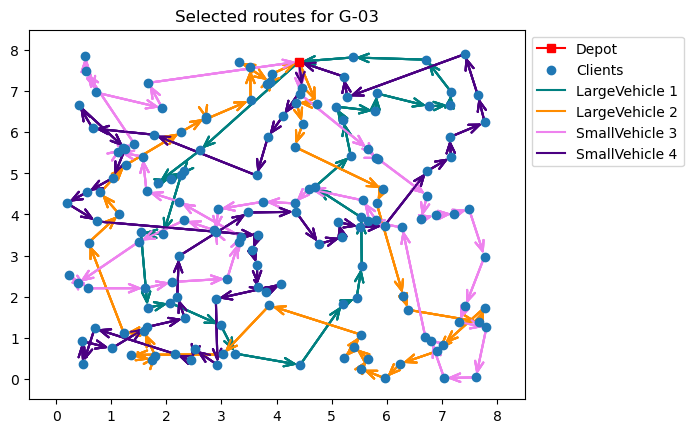

The optimal cost for the distance traveled is: 118.84 €
Route for vehicle k1: 0 -> 64 -> 69 -> 135 -> 141 -> 47 -> 67 -> 100 -> 7 -> 18 -> 60 -> 40 -> 81 -> 71 -> 84 -> 21 -> 136 -> 46 -> 61 -> 122 -> 96 -> 72 -> 146 -> 33 -> 4 -> 5 -> 89 -> 31 -> 0
Route for vehicle k2: 0 -> 15 -> 24 -> 17 -> 85 -> 142 -> 148 -> 109 -> 155 -> 131 -> 156 -> 152 -> 140 -> 25 -> 57 -> 58 -> 86 -> 14 -> 36 -> 70 -> 54 -> 34 -> 134 -> 112 -> 39 -> 77 -> 153 -> 114 -> 117 -> 79 -> 143 -> 20 -> 62 -> 138 -> 9 -> 22 -> 19 -> 110 -> 123 -> 107 -> 0
Route for vehicle k3: 0 -> 98 -> 1 -> 101 -> 121 -> 145 -> 160 -> 45 -> 32 -> 29 -> 68 -> 108 -> 95 -> 30 -> 83 -> 154 -> 104 -> 133 -> 102 -> 56 -> 90 -> 144 -> 63 -> 132 -> 41 -> 157 -> 38 -> 147 -> 2 -> 82 -> 119 -> 10 -> 76 -> 51 -> 87 -> 28 -> 118 -> 151 -> 13 -> 158 -> 99 -> 149 -> 78 -> 113 -> 75 -> 139 -> 106 -> 159 -> 120 -> 0
Route for vehicle k4: 0 -> 37 -> 52 -> 91 -> 49 -> 27 -> 130 -> 8 -> 23 -> 80 -> 128 -> 16 -> 35 -> 44 -> 65 -> 111 -> 11 -> 73 -> 3

In [11]:
############ Instance Initialization G-03 ############
name = "G-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=160,
                                                                     S1=2,
                                                                     S2=2,
                                                                     Q1=650,
                                                                     dmin=5,
                                                                     dmax=10)
############ model15 Construction ############
model13 = gp.Model("model13")
x = model13.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model13.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model13.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model13.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model13.addVar() for _ in x]
model13.update()

# Lagrangian Multiplier
multiplier = [2] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model13.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model13.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model12.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model13.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model13.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model13.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model13.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model13.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model13.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model13.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

model13.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model12.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model12.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2
model13.read("MIPStarts\G-03.sol")
    
for k in range(1, 3):
    model13.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model13.Params.TimeLimit = timelimG  # Time limit
    model13.Params.NoRelHeurTime = 2400
    model13.Params.MIPFocus = 3
    model13.Params.LogFile = name+".log"
    model13.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)

############ Plotting Solution ############
if model13.solcount >= 1:
    model13.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model13.getAttr('X', x)
    yvals = model13.getAttr('X', y)
    print_route(objective=model13.objVal, edges=selected(vals))
    times.append(model13.runtime)
    print(f"Runtime = {model13.runtime}")
    feasibility_check(yvals)
    objectives.append(model13.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-04</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 2400
Set parameter MIPFocus to value 3
Set parameter LogFile to value "G-04.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 782108 rows, 262800 columns and 95390640 nonzeros
Model fingerprint: 0x178b4938
Variable types: 130320 continuous, 132480 integer (131040 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 8s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 22s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 30s
Processing user MIP start: 0 nodes explored in subMIP, total

Elapsed time for NoRel heuristic: 48s (best bound 95.5964)
Found heuristic solution: objective 252.7140250
Found heuristic solution: objective 251.5233916
Found heuristic solution: objective 250.3174603
Found heuristic solution: objective 244.2847222
Found heuristic solution: objective 235.7806120
Found heuristic solution: objective 230.5173699
Elapsed time for NoRel heuristic: 54s (best bound 95.5964)
Found heuristic solution: objective 226.3306075
Found heuristic solution: objective 225.5860737
Found heuristic solution: objective 225.5666070
Found heuristic solution: objective 225.3573481
Found heuristic solution: objective 225.0223436
Elapsed time for NoRel heuristic: 61s (best bound 95.5964)
Found heuristic solution: objective 224.9960540
Found heuristic solution: objective 223.9704401
Found heuristic solution: objective 223.9441505
Found heuristic solution: objective 222.1496297
Found heuristic solution: objective 221.0194618
Found heuristic solution: objective 220.6550224
Elapsed

Found heuristic solution: objective 144.2787620
Elapsed time for NoRel heuristic: 708s (best bound 95.5977)
Found heuristic solution: objective 144.0802862
Elapsed time for NoRel heuristic: 731s (best bound 95.5977)
Found heuristic solution: objective 143.9068565
Found heuristic solution: objective 143.6860761
Elapsed time for NoRel heuristic: 761s (best bound 95.5977)
Found heuristic solution: objective 143.5126463
Found heuristic solution: objective 143.2303025
Elapsed time for NoRel heuristic: 811s (best bound 95.5977)
Found heuristic solution: objective 143.0568727
Elapsed time for NoRel heuristic: 845s (best bound 95.5977)
Found heuristic solution: objective 142.4472060
Elapsed time for NoRel heuristic: 901s (best bound 95.5977)
Found heuristic solution: objective 141.8699940
Elapsed time for NoRel heuristic: 944s (best bound 95.5977)
Found heuristic solution: objective 141.8098483
Found heuristic solution: objective 141.6563185
Elapsed time for NoRel heuristic: 994s (best bound 9

     0     0  103.44074    0 1955  133.46639  103.44074  22.5%     - 3731s
H    0     0                     133.4420328  103.44074  22.5%     - 3737s
     0     0  103.45684    0 1999  133.44203  103.45684  22.5%     - 3738s
     0     0  103.45714    0 1805  133.44203  103.45714  22.5%     - 3739s
     0     0  103.49567    0 1506  133.44203  103.49567  22.4%     - 3835s
     0     0  103.49936    0 1822  133.44203  103.49936  22.4%     - 3841s
     0     0  103.49991    0 1854  133.44203  103.49991  22.4%     - 3841s
     0     0  103.51741    0 1742  133.44203  103.51741  22.4%     - 3959s
     0     0  103.52542    0 2011  133.44203  103.52542  22.4%     - 3969s
     0     0  103.52602    0 2139  133.44203  103.52602  22.4%     - 3970s
     0     0  103.56828    0 1798  133.44203  103.56828  22.4%     - 4050s
     0     0  103.57086    0 2010  133.44203  103.57086  22.4%     - 4052s
     0     0  103.57243    0 1942  133.44203  103.57243  22.4%     - 4052s
     0     0  103.57262  

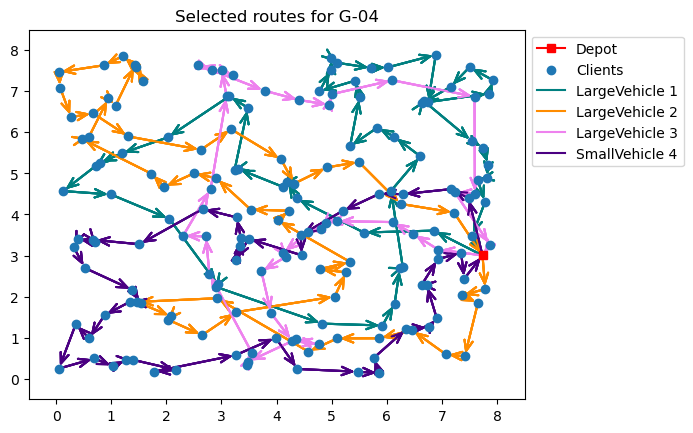

The optimal cost for the distance traveled is: 131.94 €
Route for vehicle k1: 0 -> 171 -> 4 -> 35 -> 36 -> 83 -> 101 -> 61 -> 9 -> 97 -> 8 -> 91 -> 137 -> 169 -> 126 -> 113 -> 178 -> 160 -> 51 -> 73 -> 152 -> 79 -> 10 -> 22 -> 114 -> 109 -> 42 -> 135 -> 131 -> 157 -> 108 -> 68 -> 105 -> 41 -> 37 -> 3 -> 122 -> 65 -> 85 -> 123 -> 149 -> 31 -> 71 -> 58 -> 153 -> 119 -> 166 -> 104 -> 6 -> 174 -> 2 -> 117 -> 0
Route for vehicle k2: 0 -> 124 -> 165 -> 19 -> 89 -> 172 -> 167 -> 107 -> 52 -> 63 -> 92 -> 55 -> 100 -> 47 -> 62 -> 29 -> 138 -> 129 -> 15 -> 90 -> 45 -> 30 -> 132 -> 78 -> 179 -> 69 -> 5 -> 111 -> 150 -> 180 -> 151 -> 43 -> 11 -> 146 -> 175 -> 33 -> 7 -> 16 -> 128 -> 106 -> 14 -> 162 -> 40 -> 88 -> 75 -> 77 -> 46 -> 141 -> 103 -> 0
Route for vehicle k3: 0 -> 23 -> 87 -> 121 -> 173 -> 112 -> 26 -> 84 -> 72 -> 32 -> 120 -> 86 -> 130 -> 66 -> 127 -> 20 -> 57 -> 159 -> 110 -> 158 -> 139 -> 94 -> 17 -> 44 -> 38 -> 163 -> 142 -> 96 -> 145 -> 98 -> 49 -> 148 -> 21 -> 134 -> 60 -> 13 -> 0


In [10]:
############ Instance Initialization G-04 ############
name = "G-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=180,
                                                                     S1=3,
                                                                     S2=1,
                                                                     Q1=600,
                                                                     dmin=5,
                                                                     dmax=10)
############ model14 Construction ############
model14 = gp.Model("model14")
x = model14.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model14.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model14.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model14.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model14.addVar() for _ in x]
model14.update()

# Lagrangian Multiplier
multiplier = [2] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model14.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model14.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model12.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model14.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model14.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model14.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model14.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model14.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model14.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model14.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

# model12.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model12.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model12.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2
model14.read("MIPStarts\G-04.sol")
    
for k in range(1, 3):
    model14.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model14.Params.TimeLimit = timelimG  # Time limit
    model14.Params.NoRelHeurTime = 2400
    model14.Params.MIPFocus = 3
    model14.Params.LogFile = name+".log"
    model14.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)

############ Plotting Solution ############
if model14.solcount >= 1:
    model14.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model14.getAttr('X', x)
    yvals = model14.getAttr('X', y)
    print_route(objective=model14.objVal, edges=selected(vals))
    times.append(model14.runtime)
    print(f"Runtime = {model14.runtime}")
    feasibility_check(yvals)
    objectives.append(model14.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">G-05</font>**

Set parameter TimeLimit to value 7200
Set parameter NoRelHeurTime to value 2400
Set parameter MIPFocus to value 3
Set parameter LogFile to value "G-05.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1407210 rows, 405000 columns and 203608000 nonzeros
Model fingerprint: 0x34409ca2
Variable types: 201000 continuous, 204000 integer (202000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 123s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 200s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 280s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 346s
User MIP start produced solution with objective 864.972 (352.29s)


Found heuristic solution: objective 319.2976393
Found heuristic solution: objective 318.7272028
Found heuristic solution: objective 315.7658917
Elapsed time for NoRel heuristic: 72s (best bound 96.5204)
Found heuristic solution: objective 310.9286965
Found heuristic solution: objective 303.4667263
Elapsed time for NoRel heuristic: 106s (best bound 96.5204)
Found heuristic solution: objective 271.9178841
Found heuristic solution: objective 268.5965183
Elapsed time for NoRel heuristic: 112s (best bound 96.5204)
Found heuristic solution: objective 266.3977556
Found heuristic solution: objective 263.0161570
Found heuristic solution: objective 261.2551370
Elapsed time for NoRel heuristic: 117s (best bound 97.071)
Found heuristic solution: objective 260.8068068
Found heuristic solution: objective 259.4066126
Found heuristic solution: objective 258.0151023
Found heuristic solution: objective 257.5544381
Found heuristic solution: objective 256.1419178
Found heuristic solution: objective 255.80

Found heuristic solution: objective 166.8602098
Found heuristic solution: objective 166.7130542
Elapsed time for NoRel heuristic: 1045s (best bound 97.071)
Found heuristic solution: objective 166.0289629
Found heuristic solution: objective 165.9192956
Elapsed time for NoRel heuristic: 1091s (best bound 97.071)
Found heuristic solution: objective 164.6102829
Elapsed time for NoRel heuristic: 1177s (best bound 97.071)
Found heuristic solution: objective 163.4321107
Elapsed time for NoRel heuristic: 1232s (best bound 97.071)
Found heuristic solution: objective 162.8601923
Elapsed time for NoRel heuristic: 1317s (best bound 97.071)
Found heuristic solution: objective 162.6049339
Found heuristic solution: objective 162.5970649
Found heuristic solution: objective 162.5394430
Elapsed time for NoRel heuristic: 1357s (best bound 97.071)
Found heuristic solution: objective 162.5315740
Found heuristic solution: objective 162.3710296
Found heuristic solution: objective 162.3298466
Elapsed time for

     0     0  108.39323    0 2124  155.81066  108.39323  30.4%     - 5186s
     0     0  108.39324    0 2074  155.81066  108.39324  30.4%     - 5186s
     0     0  108.43895    0 1664  155.81066  108.43895  30.4%     - 5331s
H    0     0                     155.6567493  108.43895  30.3%     - 5332s
     0     0  108.44276    0 1885  155.65675  108.44276  30.3%     - 5333s
     0     0  108.44422    0 1816  155.65675  108.44422  30.3%     - 5334s
     0     0  108.48229    0 1501  155.65675  108.48229  30.3%     - 5408s
H    0     0                     155.6069699  108.48229  30.3%     - 5436s
     0     0  108.49694    0 2035  155.60697  108.49694  30.3%     - 5437s
     0     0  108.50061    0 2133  155.60697  108.50061  30.3%     - 5439s
     0     0  108.50263    0 2160  155.60697  108.50263  30.3%     - 5439s
     0     0  108.56023    0 1639  155.60697  108.56023  30.2%     - 5576s
     0     0  108.57168    0 2140  155.60697  108.57168  30.2%     - 5582s
     0     0  108.57800  

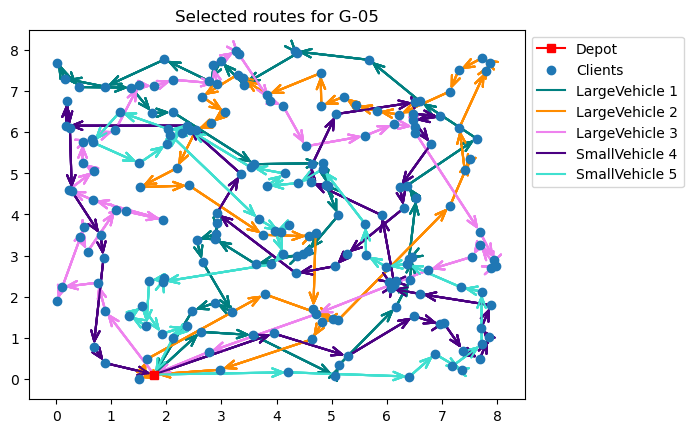

The optimal cost for the distance traveled is: 155.37 €
Route for vehicle k1: 0 -> 24 -> 95 -> 57 -> 189 -> 50 -> 41 -> 137 -> 96 -> 58 -> 69 -> 109 -> 148 -> 120 -> 178 -> 68 -> 173 -> 124 -> 200 -> 198 -> 54 -> 97 -> 36 -> 70 -> 138 -> 172 -> 133 -> 131 -> 196 -> 191 -> 5 -> 38 -> 146 -> 49 -> 187 -> 104 -> 66 -> 72 -> 128 -> 175 -> 106 -> 47 -> 107 -> 197 -> 0
Route for vehicle k2: 0 -> 29 -> 2 -> 153 -> 76 -> 116 -> 79 -> 62 -> 143 -> 123 -> 100 -> 145 -> 63 -> 159 -> 195 -> 190 -> 184 -> 154 -> 185 -> 20 -> 92 -> 174 -> 99 -> 112 -> 85 -> 75 -> 183 -> 15 -> 103 -> 181 -> 45 -> 98 -> 192 -> 78 -> 18 -> 168 -> 19 -> 88 -> 0
Route for vehicle k3: 0 -> 81 -> 65 -> 89 -> 44 -> 134 -> 102 -> 199 -> 182 -> 13 -> 135 -> 113 -> 52 -> 53 -> 144 -> 130 -> 10 -> 180 -> 9 -> 127 -> 21 -> 176 -> 194 -> 110 -> 16 -> 51 -> 94 -> 59 -> 32 -> 6 -> 132 -> 140 -> 87 -> 171 -> 39 -> 186 -> 28 -> 80 -> 82 -> 142 -> 83 -> 0
Route for vehicle k4: 0 -> 77 -> 115 -> 61 -> 1 -> 14 -> 43 -> 164 -> 46 -> 27 -

In [12]:
############ Instance Initialization G-05 ############
name = "G-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=200,
                                                                     S1=3,
                                                                     S2=2,
                                                                     Q1=585,
                                                                     dmin=5,
                                                                     dmax=10)
############ model15 Construction ############
model15 = gp.Model("model15")
x = model15.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model15.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model15.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model15.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model15.addVar() for _ in x]
model15.update()

# Lagrangian Multiplier
multiplier = [2] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model15.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model15.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model12.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model15.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model15.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model15.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model15.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model15.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model15.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model15.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

# model12.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model12.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model12.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2
model15.read("MIPStarts\G-05.sol")
    
for k in range(1, 3):
    model15.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model15.Params.TimeLimit = timelimG  # Time limit
    model15.Params.NoRelHeurTime = 2400
    model15.Params.MIPFocus = 3
    model15.Params.LogFile = name+".log"
    model15.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)
############ model15 Solving ############
# model15.reset()
# model15.Params.TimeLimit = timelimG  # Time limit
# model15.read("MIPStarts\G-05.sol")
# model15.optimize()

############ Plotting Solution ############
if model15.solcount >= 1:
    model15.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model15.getAttr('X', x)
    yvals = model15.getAttr('X', y)
    print_route(objective=model15.objVal, edges=selected(vals))
    times.append(model15.runtime)
    print(f"Runtime = {model15.runtime}")
    feasibility_check(yvals)
    objectives.append(model15.objVal)
else:
    print("No feasible solution found")

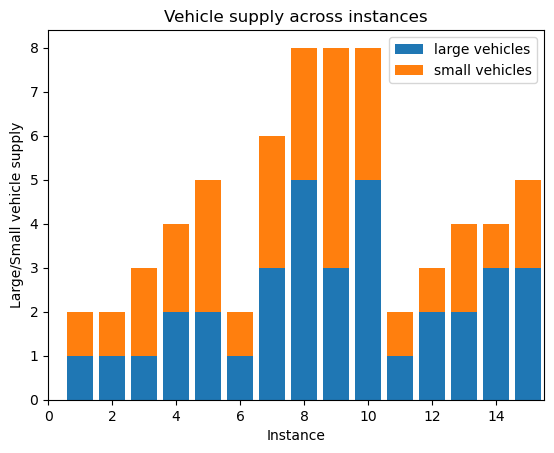

In [27]:
large = [1, 1, 1, 2, 2, 1, 3, 5, 3, 5, 1, 2, 2, 3, 3]
small = [1, 1, 2, 2, 3, 1, 3, 3, 5, 3, 1, 1, 2, 1, 2]
 
# plot bars in stack manner
plt.bar(range(1,16), large, label = "large vehicles")
plt.bar(range(1,16), small, bottom = large, label = "small vehicles")
plt.title("Vehicle supply across instances")
plt.legend(loc='best')
plt.xlabel("Instance")
plt.xlim(0,15.5)
plt.ylabel("Large/Small vehicle supply")
plt.savefig("FigXX-VehicleComparison.png", bbox_inches='tight', dpi=300)
plt.show()

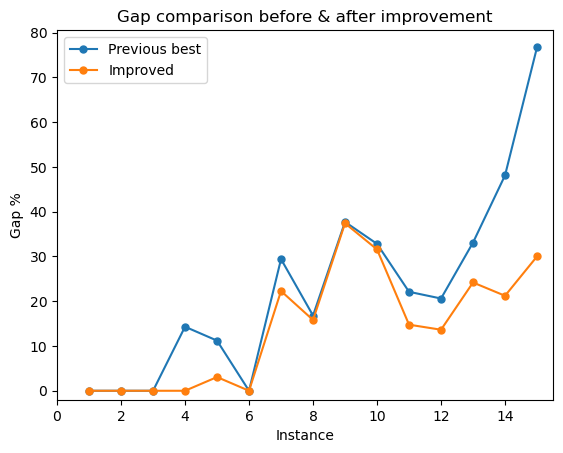

In [27]:
all_gaps_prev = [0, 0, 0, 14.3, 11.2, 0, 29.4, 16.8, 37.7, 32.8, 22.1, 20.6, 33.1, 48.1, 76.7]
all_gaps_impr = [0, 0, 0, 0, 3.06, 0, 22.27, 15.81, 37.4, 31.56, 14.76, 13.63, 24.18, 21.21, 30.0]

plt.plot(range(1,16), all_gaps_prev, '.-', markersize=10, label="Previous best")
plt.plot(range(1,16), all_gaps_impr, '.-', markersize=10, label="Improved")
plt.title("Gap comparison before & after improvement")
plt.legend(loc='best')
plt.xlabel("Instance")
plt.ylim(-2)
plt.xlim(0,15.5)
plt.ylabel("Gap %")
plt.savefig("FigXX-GapComparisonInstances.png", bbox_inches='tight', dpi=300)
plt.show()

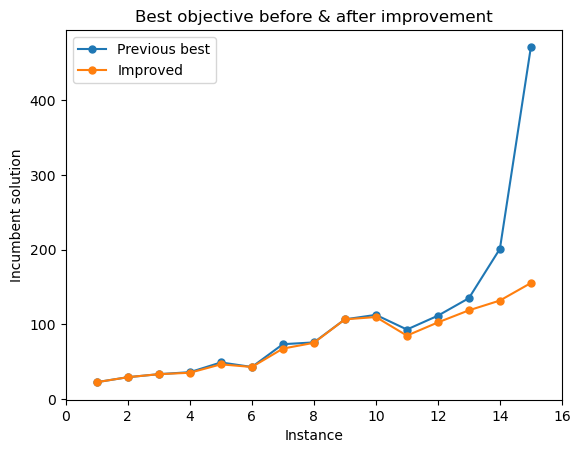

In [25]:
objs_prev = [22.55, 29.20, 33.24, 35.93, 48.97, 42.86, 73.41, 75.80, 106.7, 112.7, 93.07, 111.6, 135.1, 201.2, 471.8 ]
objs_impr = [22.55, 29.20, 33.24, 35.14, 46.42, 42.86, 67.52, 75.28, 106.7, 109.8, 84.91, 102.6, 118.8, 131.9, 155.4]

plt.plot(range(1,16), objs_prev, '.-', markersize=10, label="Previous best")
plt.plot(range(1,16), objs_impr, '.-', markersize=10, label="Improved")
plt.title("Best objective before & after improvement")
plt.legend(loc='best')
plt.xlabel("Instance")
plt.ylim(-1)
plt.xlim(0,16)
plt.ylabel("Incumbent solution")
plt.savefig("FigXX-ObjsComparisonInstances.png", bbox_inches='tight', dpi=300)
plt.show()